<a href="https://colab.research.google.com/github/GoKarolis/DL_training_leaves_classification/blob/main/KG_FastAI2_0_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About the project:

Problem:

Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, and although computer-vision based models have the promise to increase efficiency, the great variance in symptoms due to age of infected tissues, genetic variations, and light conditions within trees decreases the accuracy of detection.

Objectives:

To train a model using images of training dataset to:
 1) Accurately classify a given image from testing dataset into different diseased category or a healthy leaf; 
 2) Accurately distinguish between many diseases, sometimes more than one on a single leaf; 
 3) Deal with rare classes and novel symptoms; 
 4) Address depth perception—angle, light, shade, physiological age of the leaf; and 
 5) Incorporate expert knowledge in identification, annotation, quantification, and guiding computer vision to search for relevant features during learning.


More info about the idea:

https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview

## INIT:

In [3]:
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *
from fastai.callback.fp16 import *
from fastai.vision.widgets import *

     |████████████████████████████████| 727kB 8.3MB/s 
     |████████████████████████████████| 1.2MB 36.7MB/s 
     |████████████████████████████████| 204kB 52.3MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 


In [6]:
# !pip freeze

Parameters:

In [7]:
path = Path('/content/gdrive/MyDrive/Kaggle')
Path.BASE_PATH = path
path.ls()
images_path = path/"leaves_images"

## EDA and data preprocessing:

In [8]:
(images_path).ls()

(#1730) [Path('leaves_images/Rust_1644.jpg'),Path('leaves_images/Rust_1699.jpg'),Path('leaves_images/Healthy_1706.jpg'),Path('leaves_images/Healthy_174.jpg'),Path('leaves_images/Scab_1705.jpg'),Path('leaves_images/Healthy_1741.jpg'),Path('leaves_images/Scab_1704.jpg'),Path('leaves_images/Scab_1728.jpg'),Path('leaves_images/Rust_1710.jpg'),Path('leaves_images/Rust_1738.jpg')...]

In [9]:
leaves_data = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(flip_vert=True, mult=2, size=224, min_scale=0.75))
dls = leaves_data.dataloaders(images_path)

In [10]:
dls.vocab

['Healthy', 'Rust', 'Scab']

In [11]:
dls.dataset

(#1384) [(PILImage mode=RGB size=2048x1365, TensorCategory(1)),(PILImage mode=RGB size=2048x1365, TensorCategory(2)),(PILImage mode=RGB size=2048x1365, TensorCategory(2)),(PILImage mode=RGB size=2048x1365, TensorCategory(1)),(PILImage mode=RGB size=2048x1365, TensorCategory(1)),(PILImage mode=RGB size=2048x1365, TensorCategory(0)),(PILImage mode=RGB size=2048x1365, TensorCategory(2)),(PILImage mode=RGB size=2048x1365, TensorCategory(1)),(PILImage mode=RGB size=2048x1365, TensorCategory(1)),(PILImage mode=RGB size=2048x1365, TensorCategory(0))...]

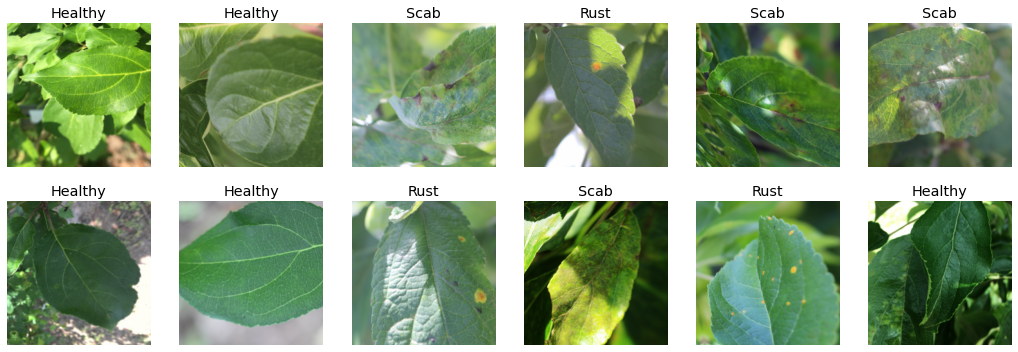

In [12]:
dls.show_batch(max_n=12, nrows=2)

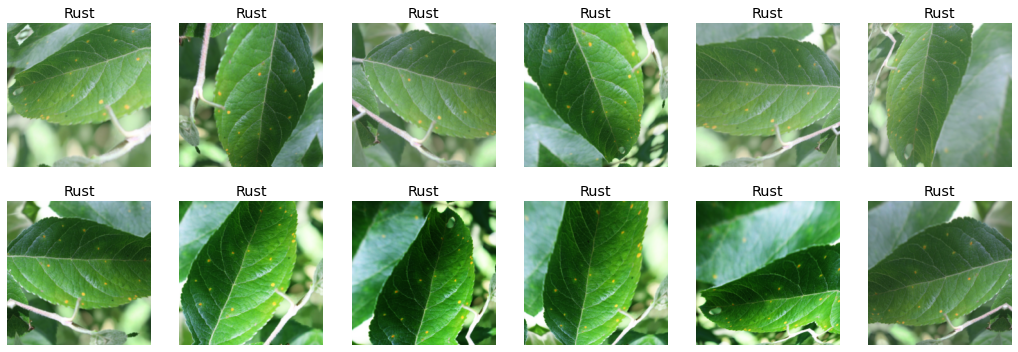

In [13]:
dls.show_batch(max_n=12, nrows=2 ,unique=True)

In [14]:
leaves_data.summary(images_path)

Setting-up type transforms pipelines
Found 1730 items
2 datasets of sizes 1384,346
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/gdrive/MyDrive/Kaggle/leaves_images/Rust_87.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=2048x1365
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/gdrive/MyDrive/Kaggle/leaves_images/Rust_87.jpg
    applying partial gives
      Rust
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=2048x1365, TensorCategory(1))


Found 1730 items
2 datasets of sizes 1384,346
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: 

## Try data on simple model:

In [15]:
# metrics = [accuracy, F1Score(), Precision(), Recall()]
metrics = [accuracy, error_rate]

Model interpretation:

In [16]:
learn = cnn_learner(dls, resnet50, metrics=metrics, loss_func = LabelSmoothingCrossEntropy()).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


-------------------

In [17]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.230900,0.945908,0.861272,0.138728,06:56


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.970046,0.796308,0.858382,0.141618,01:14
1,0.863610,0.646354,0.921965,0.078035,01:14


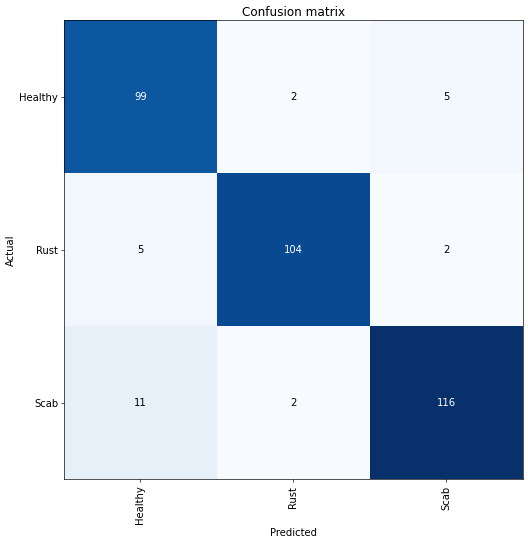

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(9,9), dpi=60)

In [19]:
interp.print_classification_report()

              precision    recall  f1-score   support

     Healthy       0.86      0.93      0.90       106
        Rust       0.96      0.94      0.95       111
        Scab       0.94      0.90      0.92       129

    accuracy                           0.92       346
   macro avg       0.92      0.92      0.92       346
weighted avg       0.92      0.92      0.92       346



In [20]:
interp.most_confused(min_val=4)

[('Scab', 'Healthy', 11), ('Healthy', 'Scab', 5), ('Rust', 'Healthy', 5)]

Data cleaning:

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [22]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Model:

resnet18, 34, 50, 101, 152

Learning rate finder:

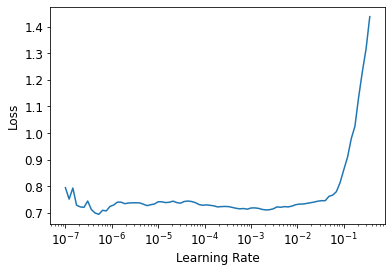

In [23]:
lr_min,lr_steep = learn.lr_find()

In [25]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 7.59e-08, steepest point: 6.31e-05


In [26]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.718759,1.151976,0.835260,0.164740,01:14
1,0.647021,0.700316,0.806358,0.193642,01:14
2,0.579962,0.417265,0.965318,0.034682,01:14


In [27]:
interp.print_classification_report()

              precision    recall  f1-score   support

     Healthy       0.86      0.93      0.90       106
        Rust       0.96      0.94      0.95       111
        Scab       0.94      0.90      0.92       129

    accuracy                           0.92       346
   macro avg       0.92      0.92      0.92       346
weighted avg       0.92      0.92      0.92       346



In [28]:
learn.unfreeze()

SuggestedLRs(lr_min=6.30957365501672e-06, lr_steep=3.311311274956097e-06)

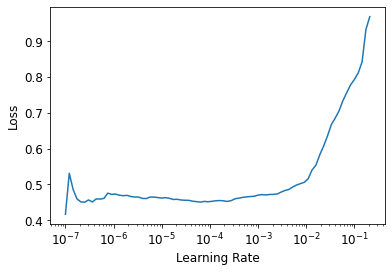

In [29]:
learn.lr_find()

Discriminative Learning Rates:

In [30]:
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(5.5e-7,1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.448570,0.382908,0.968208,0.031792,01:13
1,0.453641,0.396928,0.959538,0.040462,01:13
2,0.460445,0.390644,0.965318,0.034682,01:14
3,0.453138,0.363549,0.965318,0.034682,01:13
4,0.448270,0.379256,0.965318,0.034682,01:14
5,0.434276,0.378426,0.973988,0.026012,01:14
6,0.426311,0.363946,0.971098,0.028902,01:13
7,0.422622,0.355594,0.973988,0.026012,01:14
8,0.411406,0.352188,0.976879,0.023121,01:16
9,0.406453,0.349548,0.976879,0.023121,01:14


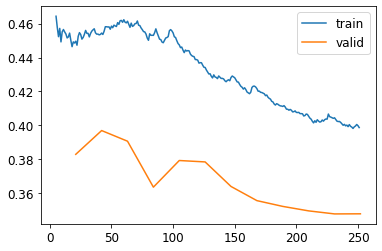

In [31]:
learn.recorder.plot_loss()

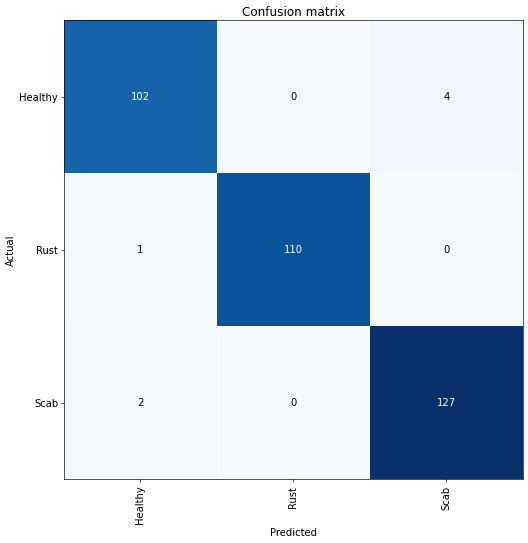

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(9,9), dpi=60)

In [33]:
interp.print_classification_report()

              precision    recall  f1-score   support

     Healthy       0.97      0.96      0.97       106
        Rust       1.00      0.99      1.00       111
        Scab       0.97      0.98      0.98       129

    accuracy                           0.98       346
   macro avg       0.98      0.98      0.98       346
weighted avg       0.98      0.98      0.98       346



In [ ]:
# interp.plot_top_losses(4, nrows=4)

## Notes




*   If the training loss is higher than val loss - you are underfitting
  If underfitting: train longer, lower lr

